# Learning goals
After today's lesson you should be able to:
- Understand the 

This week's lesson is a simplified version of:  
- The [Chapter 6 in Geographic Data Science textbook](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)
- The [Chapter 7 in Geographic Data Science textbook](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html)

# Global Spatial Autocorrelation

The notion of spatial autocorrelation relates to the existence of a "functional relationship between what happens at one point in space and what happens elsewhere" {cite}`Anselin_1988`. **Spatial autocorrelation thus has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations.** 

## Understanding Spatial Autocorrelation

In order to better understand the notion of spatial autocorrelation, it is useful to begin by considering what the world looks like in its absence. A key idea in this context is that of spatial randomness: **a situation in which the location of an observation gives no information whatsoever about its value**. In other words, a variable is spatially random if its distribution follows no discernible spatial pattern. Spatial autocorrelation can thus be defined as the "absence of spatial randomness". 

This definition is still too vague, though. So, to get more specific, spatial autocorrelation is typically categorized along two main dimensions: **sign** and **scale**. Similar to the traditional, non-spatial case, spatial autocorrelation can adopt two main forms: **positive** and **negative**. The former relates to a situation where similarity and geographical closeness go hand-in-hand. In other words, similar values are located near each other, while different values tend to be scattered and further away. It is important that the sign of these values is not relevant for the presence of spatial autocorrelation: it may be high values close to high values, *or* low values close to low values. The important bit in this context is the relationship between closeness and statistical similarity is positive. This is a fairly common case in many social contexts and, in fact, several human phenomena display  clearly positive spatial autocorrelation. **For example, think of the distribution of income, or poverty, over space: it is common to find similar values located nearby (wealthy areas close to other wealthy areas, poor population concentrated in space too).** In contrast, **negative** spatial autocorrelation reflects a situation where similar values tend to be located away from each other. In this case, statistical similarity is associated with distance. This is somewhat less common in the social sciences, but it still exists. An example can be found in phenomena that follow processes of spatial competition or situations where the location of a set of facilities aims at the highest spatial coverage. **The distribution of supermarkets of different brands, or of hospitals usually follows a pattern of negative spatial dependence.**

It can also help to understand spatial autocorrelation using the scale at which it is considered. We generally talk of global or local processes. **Global** spatial autocorrelation, on which this chapter is focused on, considers the overall trend that the location of values follows. In doing this, the study of global spatial autocorrelation makes possible statements about the degree of *clustering* in the dataset. Do values generally follow a particular pattern in their geographical distribution? Are similar values closer to other similar values than we would expect from pure chance? These are some of the questions that relate to global spatial autocorrelation. **Local** autocorrelation focuses on deviations from the global trend at much more focused levels than the entire map, and it is the subject of the next chapter.

We will explore these concepts with an applied example, interrogating the data about the presence, nature, and strength of global spatial autocorrelation. To do this, we will use a set of tools collectively known as Exploratory Spatial Data Analysis (ESDA). Analogous to its non-spatial counterpart (EDA; {cite}`Tukey1977exploratory`), ESDA has been specifically designed for this purpose, and puts space and the relative location of the observations in a dataset at the forefront of the analysis. The range of ESDA methods is wide and spans from simpler approaches like choropleth maps (previous chapter), to more advanced and robust methodologies that include statistical inference and an explicit recognition of the geographical arrangement of the data. The purpose of this chapter is to dip our toes into the latter group.

## An empirical illustration: the EU Referendum

To illustrate the notion of spatial autocorrelation and its different variants, let us turn to an example with real world data. Before the data, let us import all the relevant libraries that we will use throughout the chapter:

In [2]:
# Graphics
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns
from pysal.viz import splot
from splot.esda import plot_moran
import contextily as ctx

sns.set_context(context='paper')


# Analysis
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation



## warnings is a module that allows you to filter warnings
import warnings
## we are going to ignore all warnings (so they won't print)
warnings.filterwarnings("ignore")

In 2016, the United Kingdom ran a referendum to decide whether to remain in the European Union or to leave the club, the so called "Brexit" vote. We will use the official data from the Electoral Commission at the local authority level on percentage of votes for the Remain and Leave campaigns. There are two distinct datasets we will combine:

* Electoral Commission data on vote percentages at the local authority level. [[CSV]](http://www.electoralcommission.org.uk/__data/assets/file/0014/212135/EU-referendum-result-data.csv)
* ONS Local Authority Districts (December 2016) Generalized Clipped Boundaries in the UK WGS84. [[SHP]](https://data.gov.uk/dataset/65f48bab-e65f-491c-90f5-729eef098196/local-authority-districts-december-2016-generalised-clipped-boundaries-in-the-uk-wgs84)

The vote results are stored in a `csv` file which we read into a dataframe:

In [3]:
brexit_data_path = "https://www.dropbox.com/s/ogo2voxzkrz3dvz/brexit_vote.csv?dl=1"
ref = pd.read_csv(brexit_data_path, index_col="Area_Code")

ref.head()

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


While the shapes of the geographical units (local authority districts, in this case) are stored in a compressed GeoJSON file. We can read it directly from the `.zip` file as follows:

In [4]:
lads = gpd.read_file(
    "https://www.dropbox.com/s/xek0dim8636clhv/local_authority_districts.geojson?dl=1"
).set_index("lad16cd")
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


Although there are several variables that could be considered, we will focus on `Pct_Leave`, which measures the proportion of votes for the Leave alternative. For convenience, let us merge the vote results with the spatial data and project the output into the Spherical Mercator coordinate reference system (CRS), the preferred choice of web maps, which will allow us to combine them with contextual tiles later:

In [5]:
db = (
    gpd.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)
db.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368..."


And with these elements, we can generate a choropleth map to get a quick sense of the spatial distribution of the data we will be analyzing. Note how we use some visual tweaks (e.g. transparency through the `alpha` attribute) to make the final plot easier to read.

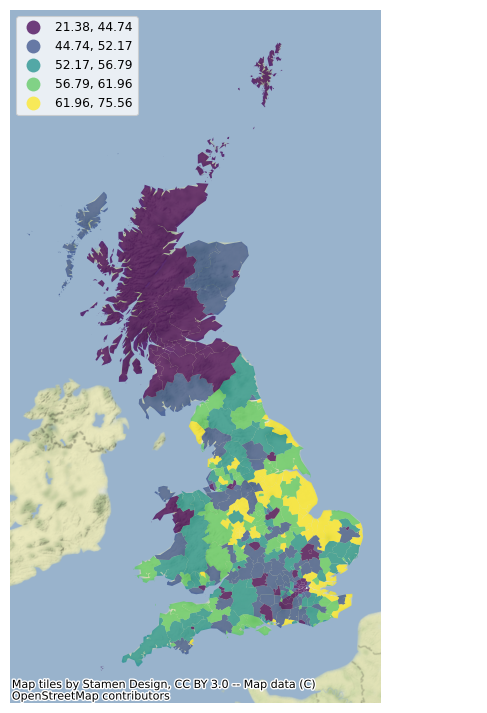

In [6]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
ctx.add_basemap(
    ax,
    crs=db.crs,
    source=ctx.providers.Stamen.TerrainBackground,
)
ax.set_axis_off()

The final piece we need before we can delve into autocorrelation is the spatial weights matrix. We will use eight nearest neighbors for the sake of the example, but the discussion in the earlier chapter on weights applies in this context, and other criteria would be valid too. We also row-standardize them. 

**Row standardization is a way of normalizing the weights so that they sum to 1 for each observation**

In [7]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"


## Global spatial autocorrelation

The map above is a good way to begin exploring the main spatial patterns in the data. At first sight, it appears to display a fair amount of positive spatial autocorrelation: local authorities with high percentages of votes to leave the EU tend to be next to each other (see, for instance, the eastern region), as are those where a much smaller proportion of their population voted to leave (with Scotland being a good example in the north). By looking at the map above, for example, we can have an educated guess about the presence of spatial autocorrelation; **but actually determining whether what we are seeing could have come from pure chance or not is usually easier said than done**.

That is exactly the purpose of indicators of global spatial autocorrelation: to leverage the power of statistics to help us first summarize the spatial distribution of values present in a map, and second obtain a formal quantification of the departure from randomness. These are statistics to characterize a map in terms of its degree of clustering and summarize it, either in a visual or numerical way. However, before we can delve into the statistics, we need to understand a core building block: the **spatial lag**. With that concept under the belt, we are in a position to build a good understanding of global spatial autocorrelation. We will gently enter it with the binary case, when observations can only take two (potentially categorical) values, before we cover the two workhorses of the continuous case: the Moran Plot and Moran's I.

### Spatial Lag

The spatial lag operator is one of the most common and direct applications of spatial weights matrices ($\textbf{W}$'s) in spatial analysis. The mathematical definition is the product of $\textbf{W}$ and the vector of a given variable. Conceptually, the spatial lag captures the behavior of a variable in the immediate surroundings of each location; in that respect, it is **akin to a local smoother of a variable**. 

We can formally express it in matrix notation as:

$$
Y_{sl} = \textbf{W} Y
$$

or, in individual notation as:

$$
y_{sl-i} = \sum_j w_{ij} y_j
$$

where $w_{ij}$ is the cell in $\textbf{W}$ on the $i$-th row and $j$-th column, thus capturing the spatial relationship between observations $i$ and $j$. $y_{sl-i}$ thus captures the product of the values and weights of each observation other than $i$ in the dataset. Because non-neighbors receive a weight of zero, $y_{sl-i}$ really captures the product of values and weights for $i$'s neighbors. If $\textbf{W}$ is binary, this will amount to the sum of the values of $i$'s neighbors (useful in some contexts, such as studies of market potential); if $W$ is row standardized, a common transformation, then $w_{ij}$ is bounded between zero and one; the spatial lag thus then becomes a "**local average**," the average value of $Y$ in the neighborhood of each observation $i$. This latter meaning is the one that will enable our analysis of spatial autocorrelation below.

As we will discover throughout this book, the spatial lag is a key element of many spatial analysis techniques and, as such, it is fully supported in Pysal. To compute the spatial lag of a given variable, `Pct_Leave` for example, we can do it as follows:

In [8]:
db["Pct_Leave_lag"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)

Let us peek into two local authority districts to get a better intuition of what is behind the spatial lag:

In [9]:
db.loc[["E08000012", "S12000019"], ["Pct_Leave", "Pct_Leave_lag"]]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


The first row (`E08000012`) represents Liverpool, which was a notorious "Remainer" island among the mostly-Leave North of England. Outside of London and Scotland, it was one of the few locations with less than majority to Leave. The second row (`S12000019`) represents Midlothian, in Scotland, where no local authority voted to leave. Although both Liverpool and Midlothian display a similar percentage of population who voted to leave (42% and 38%, respectively), the difference in their spatial lags captures the wider geographical context, which are quite different.

To end this section visually, the smoothing nature of the lag can be appreciated in the following map comparison:

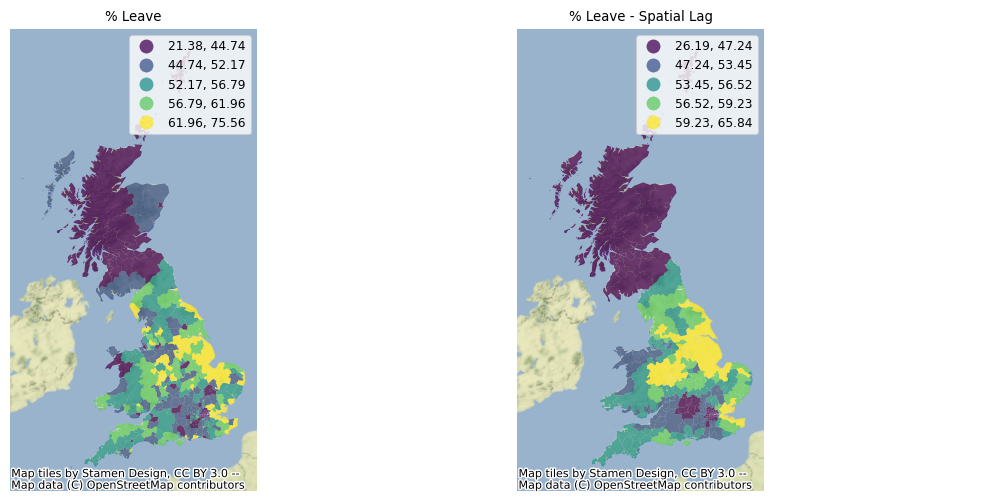

In [10]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% Leave")
ctx.add_basemap(
    ax1,
    crs=db.crs,
    source=ctx.providers.Stamen.TerrainBackground,
)

db.plot(
    column="Pct_Leave_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
ctx.add_basemap(
    ax2,
    crs=db.crs,
    source=ctx.providers.Stamen.TerrainBackground,
)

plt.show()

Stark differences on the left between immediate neighbors (as in the case of Liverpool, in the NW of England) are diminished on the map in the right. **Thus, as discussed above, the spatial lag can also smooth out the differences between nearby observations**. 

### Binary case: join counts

The spatial lag plays an important role in quantifying spatial autocorrelation. Using it, we can begin to relate the behavior of a variable at a given location to its pattern in the immediate neighborhood. Measures of global spatial autocorrelation will then use each observation to construct overall measures about the general trend in a given dataset. 

Our first dip into these measures considers a simplified case: binary values. This occurs when the variable we are interested in only takes two values. In this context, we are interested in whether a given observation is surrounded by others within the same category. For example, returning to our dataset, we want to assess the extent to which local authorities who voted to Leave tend to be surrounded by others who also voted to leave. To proceed, let us first calculate a binary variable (`Leave`) that indicates 1 if the local authority voted to leave, and zero otherwise:

In [12]:
db["Leave"] = (db["Pct_Leave"] > 50).astype(int)
db[["Pct_Leave", "Leave"]].tail()

,Pct_Leave,Leave
lad16cd,,
W06000018,57.63,1
W06000019,62.03,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1


Which we can visualize readily:

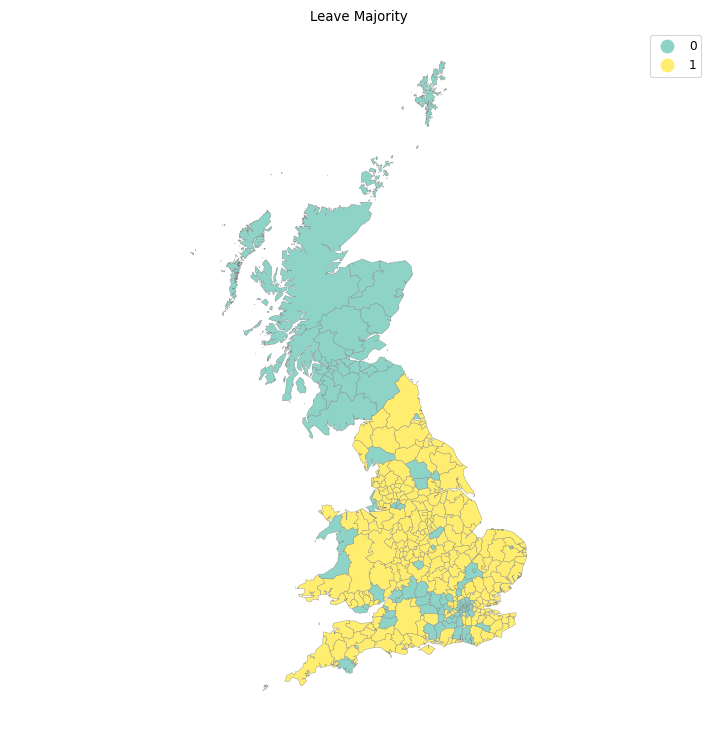

In [13]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="Leave",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set3",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Leave Majority")
plt.axis("equal")
plt.show()

Visually, it appears that the map represents a clear case of positive spatial autocorrelation: overall, there are few visible cases where a given observation is surrounded by others in the opposite category. To formally explore this initial assessment, we can use what is called a "**join count**" statistic (JC; {cite}`Cliff1981spatial`). 

Imagine a checkerboard with green (G, value 0) and yellow (Y, value 1) squares. The idea of the statistic is to count occurrences of green-green (GG), yellow-yellow (YY), or green-yellow/yellow-green (GY) joins (or neighboring pairs) on the map. In this context, both GG and YY reflect positive spatial autocorrelation, while GY captures its negative counterpart. The intuition of the statistic is to provide a baseline of how many GG, YY, and GY one would expect under the case of complete spatial randomness, and to compare this with the observed counts in the dataset. **A situation where we observe more GG/YY than expected and less GY than expected would suggest positive spatial autocorrelation; while the opposite, more GY than GG/YY, would point towards negative spatial autocorrelation.**

Since the spatial weights are only used here to delimit who is a neighbor or not, the join count statistic requires binary weights. Let us thus transform `w` back to a non-standardized state:

In [14]:
w.transform

'R'

In [15]:
w.transform = "O"

In [16]:
w.transform

'O'

We can compute the statistic as:

In [17]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["Leave"], w)
jc

As it is common throughout Pysal, we are creating an object (`jc`) that holds a lot of information beyond the value of the statistic calculated. For example, we can check how many occurrences of GG we have (note the attribute is `bb`, which originates from the original reference where the two considered classes were black and white):

In [18]:
jc.bb

871.0

how many YY occurrences our map has:

In [19]:
jc.ww

302.0

and how many GY/YG we find:

In [20]:
jc.bw

347.0

The sum of those three gives us the total number of comparisons:

In [21]:
jc.bb + jc.ww + jc.bw

1520.0

In [22]:
jc.J

1520.0

The statistic is based on comparing the actual number of joins of each class (`bb`, `ww`, `bc`) with what one would expect in a case of spatial randomness. Those expectations can be accessed as well, for the GG/YY case:

In [23]:
jc.mean_bb

727.4124124124124

and for GY joins:

In [24]:
jc.mean_bw

649.3233233233233

Statistical inference to obtain a sense of whether these values are likely to come from random chance or not can be accessed using random spatial permutations of the observed values to create synthetic maps under the null hypothesis of complete spatial randomness. `esda` generates 999 such synthetic patterns and then uses the distribution of join counts from these patterns to generate pseudo-pvalues for our observed join count statistics:

In [25]:
jc.p_sim_bb

0.001

What's a **p-value** again? The p-value is the probability that we observe the statistic that we saw (727.412 in the base of bb and 649.32 in the case of bw) in a "null hypothesis" scenario where, in this case, all the bb, ww, and bws are randomly distributed. 


</figure>
<img src="https://upload.wikimedia.org/wikipedia/en/0/00/P-value_Graph.png" alt="drawing" width="600" style="display: block; margin: 0 auto"/>
</figure>




In [26]:
jc.p_sim_bw

1.0

These results point to a clear presence of positive spatial autocorrelation, as there are a lot more joins of pairs in the same category than one would expect (`p_sim_bb`) and significantly less of opposite joins (`p_sim_bw`). We will discuss the generation of the pseudo p-values in more detail in the next section.

### Continuous case: Moran Plot and Moran's I

Once we have built some intuition around how spatial autocorrelation can be
formally assessed in the binary case, let us move to situations where the
variable of interest does not only take two values, but is instead continuous.
Probably the most commonly used statistic in this context is Moran's I {cite}`Moran1948`, which can be written as:

$$
I = \dfrac{n}{\sum_i\sum_j w_{ij}} \dfrac{\sum_i\sum_j w_{ij} \, z_i \, z_j}{\sum_i z_i^2}
$$

where $n$ is the  number of observations, $z_{i}$ is the standardized value of the variable of interest at location $i$, and $w_{ij}$ is the cell corresponding to the $i$-th row and $j$-th column of a $W$ spatial weights matrix.

In order to understand the intuition behind its math, it is useful to begin with a graphical interpretation: the Moran Plot. The Moran Plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its *spatial lag*. In order to be able to interpret values as above or below the mean, the variable of interest is usually standardized by subtracting its mean and dividing by the standard deviation of the variable:

In [27]:
db["Pct_Leave_std"] = (db["Pct_Leave"] - db["Pct_Leave"].mean())/db["Pct_Leave"].std()
db["Pct_Leave_lag_std"] = (
    db["Pct_Leave_lag"] - db["Pct_Leave_lag"].mean()
)/db["Pct_Leave_lag"].std()

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot in Python:

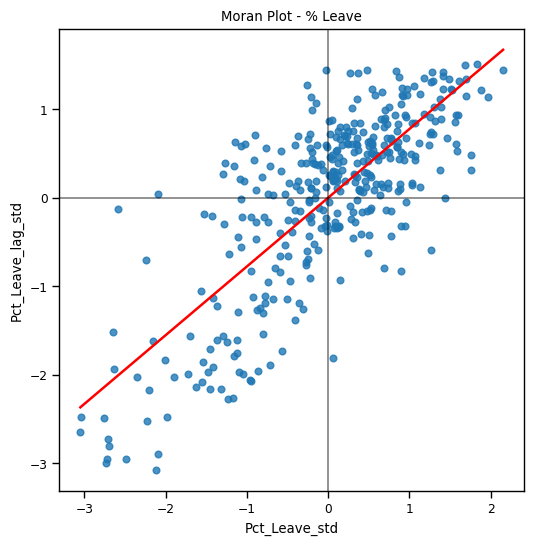

In [28]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="Pct_Leave_std",
    y="Pct_Leave_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()

The figure above displays the relationship between the standardized "Leave" voting percentage in a local authority and its spatial lag which, because the $W$ used is row-standardized, can be interpreted as the **average standardized density of the percent Leave vote in the neighborhood of each observation**. In order to guide the interpretation of the plot, a linear fit is also included. This line represents the best linear fit to the scatter plot or, in other words, what is the best way to represent the relationship between the two variables as a straight line.

The plot displays a positive relationship between both variables. This is indicates the presence of positive spatial autocorrelation: **similar values tend to be located close to each other. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values**. This, however, does not mean that this is the only case in the dataset: there can of course be particular situations where high values are surrounded by low ones, and *vice versa*. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space. In the context of the example, this can be interpreted along the lines of: local authorities where people voted in high proportion to leave the EU tend to be located nearby other regions that also registered high proportions of Leave vote. In other words, **we can say the percentage of Leave votes is spatially autocorrelated in a positive way**.

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarizes the figure. This is exactly what Moran's I, as formally expressed above, is meant to do.

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is a close connection between the two: **the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot**.

In order to calculate Moran's I in our dataset, we can call a specific function in `esda` directly (before that, let us row standardized the `w` object again):

In [29]:
w.transform = "R"
moran = esda.moran.Moran(db["Pct_Leave"], w)

The method `Moran` creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:

In [30]:
moran.I

0.6454521298096587

The other bit of information we will extract from Moran's I relates to statistical inference: how likely is the pattern we observe in the map and Moran's I captures in its value to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics? To obtain insight into these questions, `esda` performs a simulation and returns a measure of certainty about how likely it is to obtain a pattern like the one we observe under a spatially random process.  This is summarized in the `p_sim` attribute:

In [31]:
moran.p_sim

0.001

The value is calculated as an empirical p-value that represents the proportion of realizations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran's I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

That is a very low value, particularly considering it is actually the minimum value we could have obtained given the simulation behind it used 999 permutations (default in `esda`) and, by standard terms, it would be deemed statistically significant. We can elaborate a bit further on the intuition behind the value of `p_sim`. **If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, only 0.01% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.99% of the random maps would receive a smaller (absolute) value of Moran's I**. If we remember again that the value of Moran's I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values over space we observe for the percentage of Leave votes is more concentrated than if we were to randomly shuffle the vote proportions among the map, hence the statistical significance. As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively autocorrelated over space. Indeed, the overall spatial pattern in the EU Referendum vote was highly marked: nearby areas tended to vote alike.

Thanks to the `splot` visualization module in Pysal, we can obtain a quick representation of the statistic that combines the Moran Plot (right) with a graphic of the empirical test that we carry out to obtain `p_sim` (left):

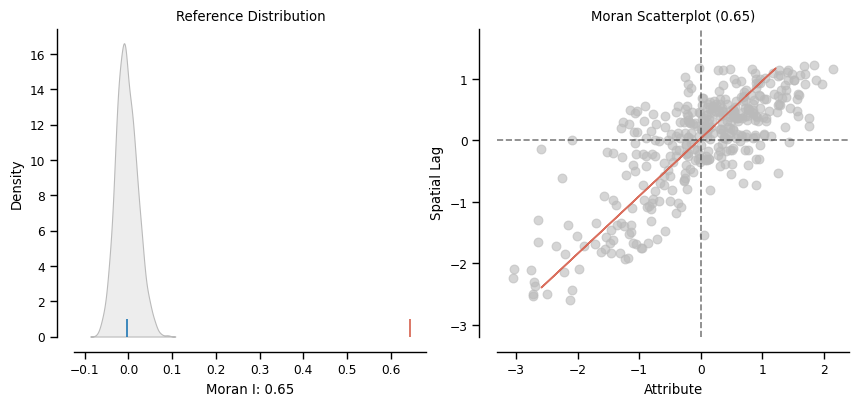

In [32]:
plot_moran(moran);

On the left panel we can see in gray the empirical distribution generated from simulating 999 random maps with the values of the `Pct_Leave` variable and then calculating Moran's I for each of those maps. The blue rug signals the mean. In contrary, the red rug shows Moran's I calculated for the variable using the geography observed in the dataset. It is clear the value under the observed pattern is significantly higher than under randomness. This insight is confirmed on the right panel, which shows an equivalent plot to the Moran Plot we created above.

### Other global indices (skip during class)

Moran's I is probably the most widely used statistic for global spatial autocorrelation, however it is not the only one. In this final part of the chapter, we introduce two additional measures that are common in applied work. Although they all consider spatial autocorrelation, they differ in how the concept is tackled in the specification of each test.

#### Geary's C

The contiguity ratio $c$, proposed by {cite}`Geary1954contiguity`, is given by:

$$
C = \dfrac{(n-1)}
          {2 \sum_i \sum_j w_{ij}} 
    \dfrac{\sum_i \sum_j w_{ij} (y_i - y_{j})^2}
          {\sum_i (y_i - \bar{y})^2}
$$

where $n$ is the number of observations, $w_{ij}$ is the cell in a binary matrix $W$ expressing whether $i$ and $j$ are neighbors ($w_{ij}=1$) or not ($w_{ij}=1$), $y_i$ is the $i$-th observation of the variable of interest, and $\bar{y}$ is its sample mean. When compared to Moran's I, it is apparent both measures compare the relationship of $Y$ within each observation's local neighborhood to that over the entire sample. However, there are also subtle differences. While Moran's I takes cross-products on the standardized values, Geary's C uses differences on the values without any standardization. 

Computationally, Geary's C is more demanding, but it can be easily computed using `esda`:

In [ ]:
geary = esda.geary.Geary(db["Pct_Leave"], w)

Which has a similar way of accessing its estimate:

In [ ]:
geary.C

Inference is performed in a similar way as with Moran's I. We can perform a simulation that allows us to draw an empirical distribution of the statistic under the null of spatial randomness, and then compare it with the statistic obtained when using the observed geographical distribution of the data. To access the pseudo p-value, calculated as in the Moran case, we can call `p_sim`:

In [ ]:
geary.p_sim

In this case, Geary's C points in the same direction as Moran's I: there is clear indication that the statistic we calculate on the observed dataset is different from what would be expected in a situation of pure spatial randomness. Hence, from this analysis, we can also conclude spatial autocorrelation is present.

#### Getis and Ord's G

Originally proposed by {cite}`Getis1992analysis`, the $G$ is the global version of a family of statistics of spatial autocorrelation based on distance. The $G$ class of statistics is conceived for points, hence the use of a distance $W$, but it can also be applied to polygon data if a binary spatial weights matrix can be constructed. Additionally, it is designed for the study of positive variables with a natural origin. The $G$ can be expressed as follows:

$$
G(d) = \dfrac{ \sum_i \sum_j w_{ij}(d) \, y_i \, y_j }
             { \sum_i \sum_j y_i \, y_j }
$$

where $w_{ij}(d)$ is the binary weight assigned on the relationship between observations $i$ and $j$ following a distance band criterion. $G$ was originally proposed as a measure of concentration rather than of spatial autocorrelation. As such, it is well suited to test to what extent similar values (either high or low) tend to co-locate. In other words, the $G$ is a statistic of *positive* spatial autocorrelation. This is usually the interest in most Geographic Data Science applications. However, it is important to note that, because $G$ can be understood as a measure of the intensity with which $Y$ is concentrated, the statistic is not able to pick up cases of *negative* spatial autocorrelation.

To illustrate its computation, let us calculate a binary distance band $W$. To make sure every observation has at least one neighbor, we will use the `min_threshold_distance` method and project the dataset into the Ordnance Survey CRS (`EPSG` code 27700), expressed in meters:

In [ ]:
db_osgb = db.to_crs(epsg=27700)
pts = db_osgb.centroid
xys = pd.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

For every local authority to have a neighbor, the distance band needs to at least be about 181 Km. This information can then be passed to the `DistanceBand` constructor:

In [ ]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

At this point, we are ready to calculate the global $G$ statistic:

In [ ]:
gao = esda.getisord.G(db["Pct_Leave"], w_db)

Access to the statistic (`gao.G`) and additional attributes can be gained in the same way as with the previous statistics:

In [ ]:
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Similarly, inference can also be carried out by relying on computational simulations that replicate several instances of spatial randomness using the values in the variable of interest, but shuffling their locations. In this case, the pseudo P-value computed suggests a clear departure from the hypothesis of no concentration.



## Q.1 
Sometimes referendums require more than 50% to make the change they ask about. Let us imagine the EU referendum required 60% to succeed on leaving the EU.
1. Use `Pct_Leave` to create a binary variable that takes a value of 1 if the percentage was larger than 60, 0 otherwise. (2 pts)
2. Create a choropleth with the newly created variable. Are there any differences in the geographical pattern of the vote to leave the EU? (You can just describe this without using any statistics) (2 pts)
3. Re-compute the Join Counts statistic for this new variable. What can we conclude? Are there any notable changes in the extent to which "Leave" votes were distributed spatially? (2 pts)



In [65]:
## insert your code here
db["Leave_60"] = (db["Pct_Leave"] > 60).astype(int)

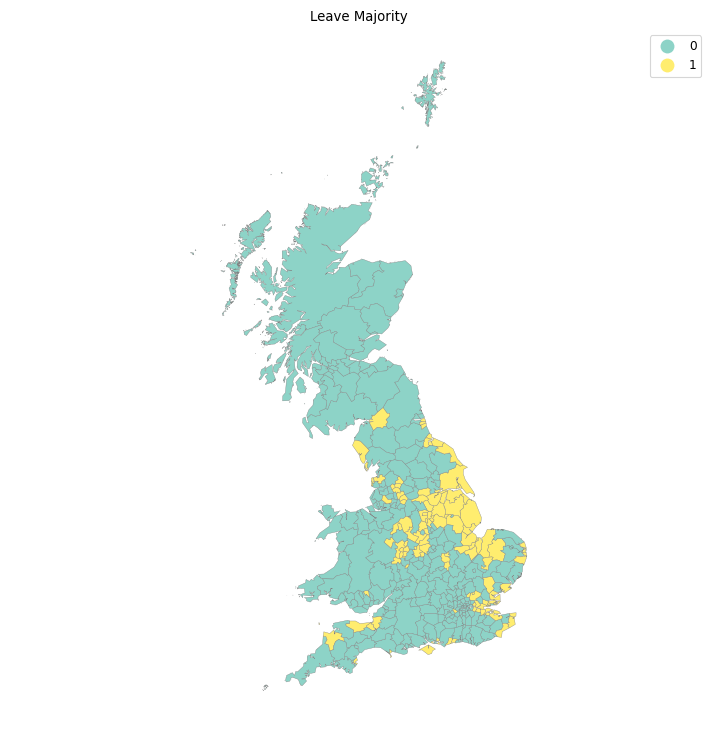

In [66]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="Leave_60",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set3",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Leave Majority")
plt.axis("equal")
plt.show()

There is much less of spatial difference in Leave vs Remain Regions now. In the figure above, most local authorities do not satisfy the 60% leave vote requirement, aside from western areas of the country. This suggests that most areas that were labelled as "leave" in the previous figure had a fairly even split in the vote. 

In [120]:
seed(1234)
w.transform = "O"
jc_60 = esda.join_counts.Join_Counts(db["Leave_60"], w)

print(jc_60.bb)
print(jc_60.ww)
print(jc_60.bw)

print(jc_60.mean_bb)
print(jc_60.mean_bw)

441.0
2228.0
1131.0
271.86836836836835
1495.9044044044044


In [116]:
jc_60.p_sim_bb

0.001

In [117]:
jc_60.p_sim_bw

1.0

There is a significantly greater amount of similar-colored neighbor areas (GG/YY) compared with the expected calculated statistic, and a fewer amount of different-colored areas (GY) compared with the expected calculated statistic. However, the smallest category of neighbor pairs is the YY area neighbors, suggesting once again that there are few authorities that satisfy the 60% vote threshold.

## Q.2

Return to the original ref table and pull out the `Pct_Rejected` variable. Using $k$-nearest neighbor weights, can you find the $k$ where Moran's $I$ is largest? Use a range from 1 to 20. (2 pts)

In [56]:
#Create geodataframe with new variable
db_reject = (
    gpd.GeoDataFrame(
        lads.join(ref[["Pct_Rejected"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Rejected", "geometry"]
    ]
    .dropna()
)

In [113]:

#Create empty list to store Moran's I 
moran_val = [None] * 20
#Loop over k values and calculate corresponding weights
for i in range(20):
    #Set K for nearest neighbor calculation
    K = i + 1
    #Calculate weight
    w = weights.distance.KNN.from_dataframe(db_reject, k= K)
    w.transform = "R"
    #Calculate Moran's I and save to list
    moran = esda.moran.Moran(db_reject["Pct_Rejected"], w)
    moran_val[i] = moran.I

#Find index of max value
max_index = moran_val.index(max(moran_val))
print("k value of max moran statistic is", max_index + 1)

k value of max moran statistic is 1


Make a plot of the Moran's $I$ for each $k$ you evaluate to show the relationship between the two.  (2 pts)

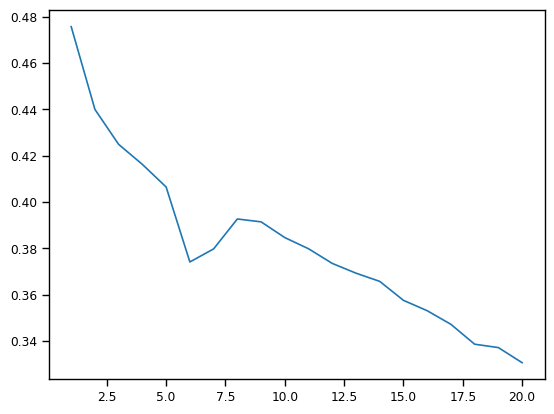

In [70]:
### Insert you code here 
K_val = [i+1 for i in range(20)]

plt.plot(K_val, moran_val)






Explain the intuition for why you saw this relationship. (2 pts)

Based on the figure above, it seems that as k increases, the Moran's I statistic calculated decreases. This suggests that as the number of neighbors increases, there is less of a spatial relationship between the percent of ballots rejected in one local authority compared to its neighbors. In fact the highest relationship calculated is when k = 1. This is understandable, as you wouldn't expect to see an obvious spatial relationship surrounding rejected ballots throughout Britain.  

# Local Spatial Autocorrelation

Local measures of spatial autocorrelation focus on the relationships between _each_ observation and its surroundings, rather than providing a single summary of these relationships across the map. In this sense, **they are not summary statistics but scores that allow us to learn more about the spatial structure in our data**. The general intuition behind the metrics however is similar to that of global ones. Some of them are even mathematically connected, where the global version can be decomposed into a collection of local ones. One such example are Local Indicators of Spatial Association (LISAs) {cite}`Anselin1995local`, which we use to build the understanding of local spatial autocorrelation, and on which we spend a good part of the chapter. 

Once such concepts are firmed, we introduce a couple alternative statistics that present complementary information or allow us to obtain similar insights for categorical data. Although very often these statistics are used with data expressed in geo-tables, there is nothing fundamentally connecting the two. In fact, the application of these methods to large surfaces is a promising area of work. For that reason, we close the chapter with an illustration of how one can run these statistics on data stored as surfaces.

## An empirical illustration: the EU Referendum

We continue with the same dataset about Brexit voting that we examined in the previous chapter.

Although there are several variables that could be considered, we will focus on `Pct_Leave` again, which measures the proportion of votes in the UK Local Authority that wanted to Leave the European Union. With these elements, we can generate a choropleth to get a quick sense of the spatial distribution of the data we will be analyzing. Note how we use some visual tweaks (e.g., transparency through the `alpha` attribute) to make the final plot easier to read.

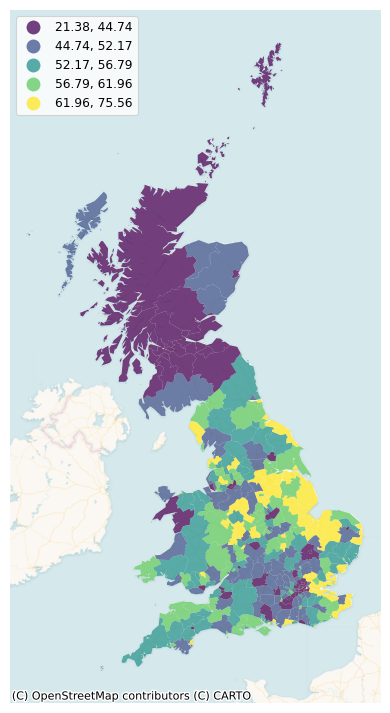

In [71]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
ctx.add_basemap(
    ax,
    crs=db.crs,
    source=ctx.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

Here, we will use eight nearest neighbors for the sake of the example.

In [72]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

## Motivating Local Spatial Autocorrelation

To better understand the underpinnings of local spatial autocorrelation, we return to the Moran Plot as a graphical tool. In this context, it is more intuitive to represent the data in a standardised form, as it will allow us to more easily discern a typology of spatial structure. Let us first calculate the spatial lag of our variable of interest:

In [73]:
db["w_Pct_Leave"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)

And their respective standardized versions, where we subtract the average and divide by the standard deviation:

In [74]:
db["Pct_Leave_std"] = (db["Pct_Leave"] - db["Pct_Leave"].mean())/db["Pct_Leave"].std()
db["w_Pct_Leave_std"] = (db["w_Pct_Leave"] - db["w_Pct_Leave"].mean())/db["w_Pct_Leave"].std()

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot:

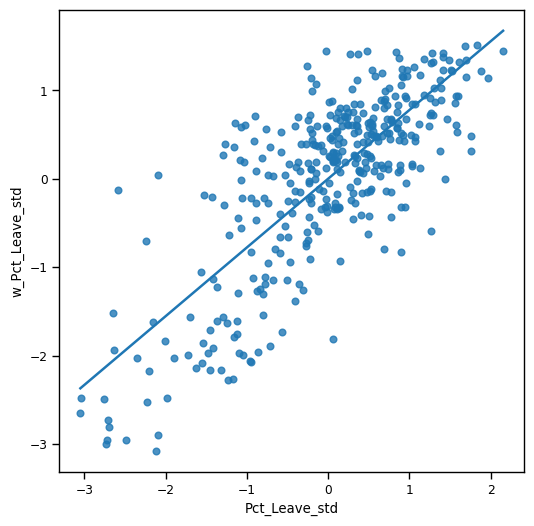

In [75]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
);

Using standardized values, we can immediately divide each variable (the percentage that voted to leave, and its spatial lag) in two groups: those with above-average leave voting, which have positive standardized values; and those with below-average leave voting, which feature negative standardized values. Applying this thinking to both the percentage to leave and its spatial lag, divides a Moran Plot in four quadrants. Each of them captures a situation based on whether a given area displays a value above the mean (high) or below (low) in either the original variable (`Pct_Leave`) or its spatial lag (`w_Pct_Leave_std`). Using this terminology, we name the four quadrants as follows: high-high (HH) for the top-right, low-high (LH) for the top-left, low-low (LL) for the bottom-left, and high-low (HL) for the bottom right. Graphically, we can capture this as follows:

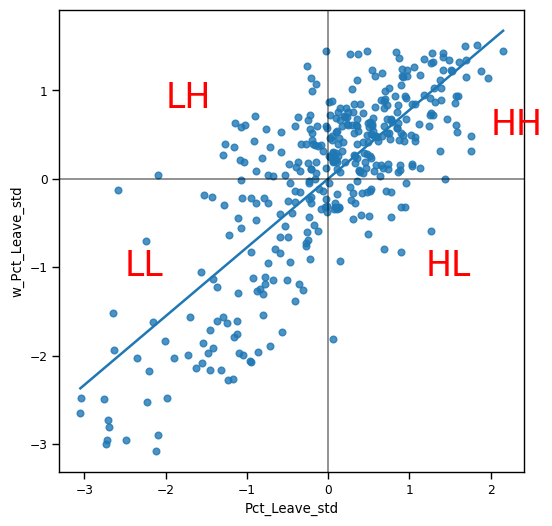

In [76]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(2.0, .5, "HH", fontsize=25, c="r")
plt.text(1.2, -1.1, "HL", fontsize=25, c="r")
plt.text(-2.0, .8, "LH", fontsize=25, c="r")
plt.text(-2.5, -1.1, "LL", fontsize=25, c="r")
# Display
plt.show()

## Local Moran's $I_i$

The core idea of a local Moran's $I_i$ is to identify cases in which the value of an observation and the average of its surroundings is either more similar (HH or LL in the scatterplot above) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation. This results in as many statistics as original observations. The formal representation of the statistic can be written as:

$$
I_i = \dfrac{z_i}{m_2} \displaystyle\sum_j w_{ij} z_j \; ; \; m_2 = \dfrac{\sum_i z_i^2}{n}
$$

where $m_2$ is the second moment (variance) of the distribution of values in the data, $z_i = y_i - \bar{y}$, $w_{i,j}$ is the spatial weight for the pair of observations $i$ and $j$, and $n$ is the number of observations.

LISAs are widely used in many fields to identify geographical clusters of values or find geographical outliers. They are a useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work. For these reasons, they have a prime place in the geographic data science toolbox. Among many other applications, LISAs have been used to identify geographical clusters of poverty {cite}`Dawson2018`, map ethnic enclaves {cite}`Johnston2010EPA`, delineate areas of particularly high/low economic activity {cite}`Torres2014`, or identify clusters of contagious disease {cite}`zhang2020`. The Local Moran's $I_i$ statistic is only one of a wide variety of LISAs that can be used on many different types of spatial data.

In Python, we can calculate LISAs in a very streamlined way thanks to `esda`. To compute local Moran statistics, we use the `Moran_Local` function:

In [77]:
lisa = esda.moran.Moran_Local(db["Pct_Leave"], w)

We need to pass the variable of interest—proportion of Leave votes in this context—and the spatial weights that describes the neighborhood relations between the different areas that make up the dataset. This creates a LISA object (`lisa`) that has a number of attributes of interest. The local indicators themselves are in the `Is` attribute and we can get a sense of their distribution using `seaborn`:

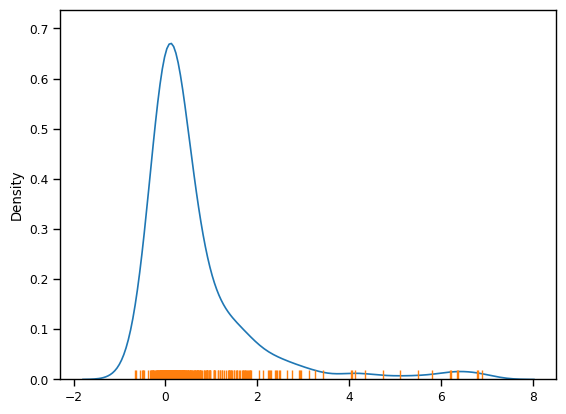

In [78]:
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

The figure reveals a rather skewed distribution of local Moran's $I_i$ statistics. This outcome is due to the dominance of positive forms of spatial association, implying most of the local statistic values will be positive. Here it is important to keep in mind that the high positive values arise from value similarity in space, and this can be due to either high values being next to high values *or* low values next to low values. The local $I_i$ values alone cannot distinguish these two cases.

The values in the left tail of the density represent locations displaying negative spatial association. There are also two forms, a high value surrounded by low values, or a low value surrounded by high valued neighboring observations. And, again, the  $I_i$ statistic cannot distinguish between the two cases.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember we are calculating a statistic for every single observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. In this context, a choropleth can help. At first glance, this may seem to suggest that a choropleth of the $I_i$  values would be a useful way to visualize the spatial distribution. We can see such map in the top-left panel of the figure below and, while it tells us whether the local association is positive (HH/LL) or negative (HL/LH), it cannot tell, for example, whether the yellow areas in Scotland are similar to those in the eastern cluster of yellow areas. Are the two experiencing similar patterns of spatial association, or is one of them HH and the other LL? Also, we know that values around zero will not be statistically significant. Which local statistics are thus significant and which ones non-significant from a statistical point of view? In other words, which ones can be considered statistical clusters and which ones mere noise?

To answer these questions, we need to bring in additional information that we have computed when calculating the LISA statistics. We do this in four acts. The first one we have already mentioned: a straighforward choropleth of the local statistic of each area. The other three include information on the quadrant each area is assigned into, whether the statistic is considered significant or not, and a combination of those two in a single so-called _cluster_ map. A handy tool in this context is the `splot` library, part of the Pysal family, which provides a lightweight visualisation layer for spatial statistics:

In [79]:
from splot import esda as esdaplot

With all pieces in place, let's first get busy building the figure:

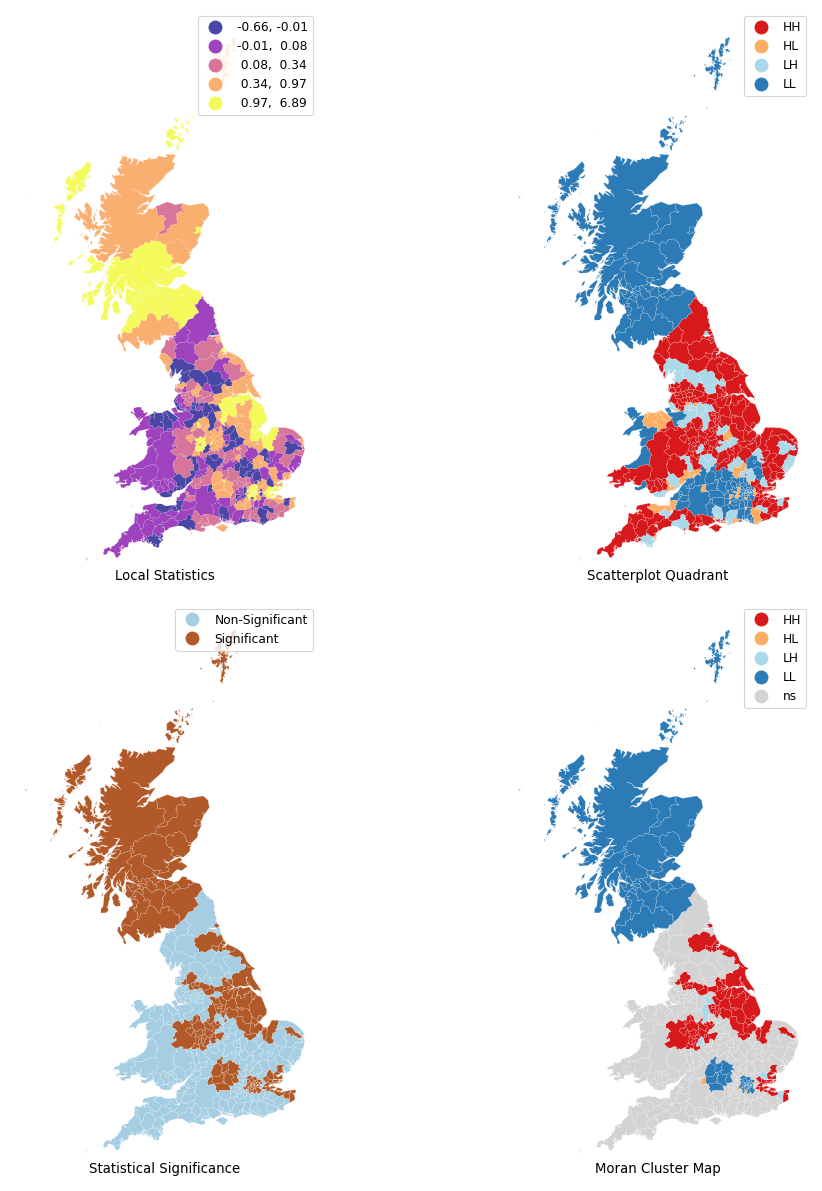

In [80]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

The purple and yellow locations in the top-right map display the largest magnitude (positive and negative values) for the local statistics $I_i$. Yet, remember this signifies positive spatial autocorrelation, which can be of high _or_ low values. This map thus cannot distinguish between areas with low support for the Brexit vote and those highly in favour.

To distinguish between these two cases, the map in the upper-right shows the location of the LISA statistic in the quadrant of the Moran Scatter plot. This indicates whether the positive (or negative) local association exists within a specific *quadrant*, such as the High-High quadrant. This information is recorded in the `q` attribute of the `lisa` object:

In [81]:
lisa.q[:10]

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1])

The correspondence between the numbers in the `q` attribute and the actual quadrants is as follows: `1` represents observations in the HH quadrant, `2` those in the LH one, `3` in the LL region, and `4` in the HL quadrant. Comparing the two maps in the top row reveals that the positive local association in Scotland is due to low support for Brexit, while the positive local association in the south is among local authorities that strongly support Brexit. Overall, we can obtain counts of areas in each quadrant as follows:

In [82]:
counts = pd.value_counts(lisa.q)
counts

1    183
3    113
2     50
4     34
dtype: int64

Showing that the high-high (1), and low-low (3), values are predominant. Care must be taken, however, in the interpretation of these first two maps, as the underlying **statistical significance of the local values has not been considered**. We have simply mapped the raw LISA value alongside the quadrant in which the local statistic resides. To statistical significance, the bottom left map distinguishes those polygons whose pseudo p-value is above (_"Non-Significant"_) or below (_"Significant"_) the threshold value of 5% we use in this context. An examination of the map suggests that quite a few local authorities have local statistics that are small enough so as to be compatible with pure chance. 

**Therefore, in order to focus on the areas that are most promising, we need to include significance information alongside the quadrant and local statistic.** Together, this "cluster map" (as it is usually called) extracts significant observations -those that are highly unlikely to have come from pure chance- and plots them with a specific color depending on their quadrant category. All of the needed pieces are contained inside the `lisa` object we have created above and, if passed in tandem with the geo-table containing the geographies it relates to, `splot` will make a cluster map for us.

Reading the clustermap reveals a few interesting aspects that would have been hard to grasp by looking at the other maps only and that are arguably more relevant for an analysis of the data. First, **fewer than half of polygons that have degrees of local spatial association strong enough to reject the idea of pure chance**:

In [83]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

41.31578947368421

A little over 42% of the local authorities are considered, by this analysis, to be part of a spatial cluster. Second, we identify three clear areas of low support for leaving the EU: Scotland, London, and the area around Oxford (North-West of London). And third, although there appeared to be many areas with concentrated values indicating high support, it is only the region in the North-East and West of England whose spatial concentration shows enough strength to reasonably rule out pure chance.

Before we move on from the LISA statistics, let's dive into a bit of the data engineering required to "export" significance levels and other information, as well as dig a bit further into what these numbers represent. The latter is useful if we need to work with them as part of a broader data pipeline. So far, cluster maps have been handled by `splot`, but there is quite a bit that happens under the hood. If we needed to recreate one of its maps, or to use this information in a different context, we would need to extract them out of our `lisa` object, and link them up to the original `db` table. Here is one way you can do this.

First, we pull the information computed in `lisa` and insert it in the main data table:

In [84]:
# Assign pseudo P-values to `db`
db["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
db["sig"] = sig
# Print top of the table to inspect
db[["sig", "p-sim"]].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.011
E06000002,1,0.009
E06000003,1,0.014
E06000004,1,0.012
E06000010,1,0.018


In [85]:
# Print bottom of the table to inspect
db[["sig", "p-sim"]].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.492
W06000019,0,0.491
W06000021,0,0.485
W06000022,0,0.351
W06000023,0,0.301


Thus, the first five values are statistically significant, while the last five observations are not.

Let us stop for a second on these two steps. First, we consider the `sig` column. Akin to global Moran's I, `esda` automatically computes a pseudo p-value for each LISA. Because some instances of the LISA statistics may not be statistically significant, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar value in random maps. A few different ways of generating random maps are considered by `esda`, but we focus on a strategy that actually simulates hundreds of thousands of random maps to get a rough idea of the possible local statistic values at each local authority given the data we saw. In addition, we follow a similar reasoning as with global Moran's I and use 5% as the threshold for statistical significance. To identify these values, we create a variable, `sig`, that contains `True` if the p-value of the observation satisfies the condition, and `False` otherwise.

Next, we construct our quadrant values using the `q` attribute which records the Moran Scatterplot quadrant for each local value. However, we now mask these values using the newly created binary significance measure `sig`, so only observations in a quadrant that are considered significant are labeled as part of that given quadrant. The remainder are labelled as non-significant.

In [86]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
db["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=db.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
db["labels"].head()

lad16cd
E06000001    HH
E06000002    HH
E06000003    HH
E06000004    HH
E06000010    HH
Name: labels, dtype: object

These cluster labels are meaningful if you know of the Moran Plot. To help making them a bit more intuitive, a terminology that is sometimes used goes as follows. Positive forms of local spatial autocorrelation are of two types. First, HH observations, which we can term "hot spots", represent areas where values at the site and its surroundings are larger than average. Second, LL observations, significant clusters of low values surrounded by low values, are sometimes referred to as "cold spots". Negative forms of local spatial autocorrelation also include two cases. When the focal observation displays low values but its surroundings have high values (LH), we call them "doughnuts". Conversely, areas with high values but neighboured by others with low values (HL) can be referred to as "diamonds in the rough". We note this terminology is purely mnemonic, but recognise in some cases it can help remembering the interpretation of local statistics. 

After building these new columns, analysis on the overall trends of LISA statistics is more straightforward than from the `lisa` object. For example, an overview of the distribution of labels is one line away:

In [87]:
db["labels"].value_counts()

Non-Significant    223
HH                  75
LL                  71
LH                   7
HL                   4
Name: labels, dtype: int64

This shows, for one, that most local statistics are *not* statistically significant. Among those that are, we see many more hotspots/coldspots than doughnuts/diamonds-in-the-rough. This is consistent with the skew we saw in the distribution of local statistics earlier. 

# Q1
 Do the same Local Moran analysis done for `Pct_Leave`, but using `Pct_Turnout`. Is there a geography to how involved people were in different places? Where was turnout percentage (relatively) higher or lower? (5 pts)

In [90]:
db2 = (
    gpd.GeoDataFrame(
        lads.join(ref["Pct_Turnout"]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Turnout", "geometry"]
    ]
    .dropna()
)
w2 = weights.distance.KNN.from_dataframe(db2, k=8)
w2.transform = "R"

In [91]:
lisa2 = esda.moran.Moran_Local(db2["Pct_Turnout"], w2)

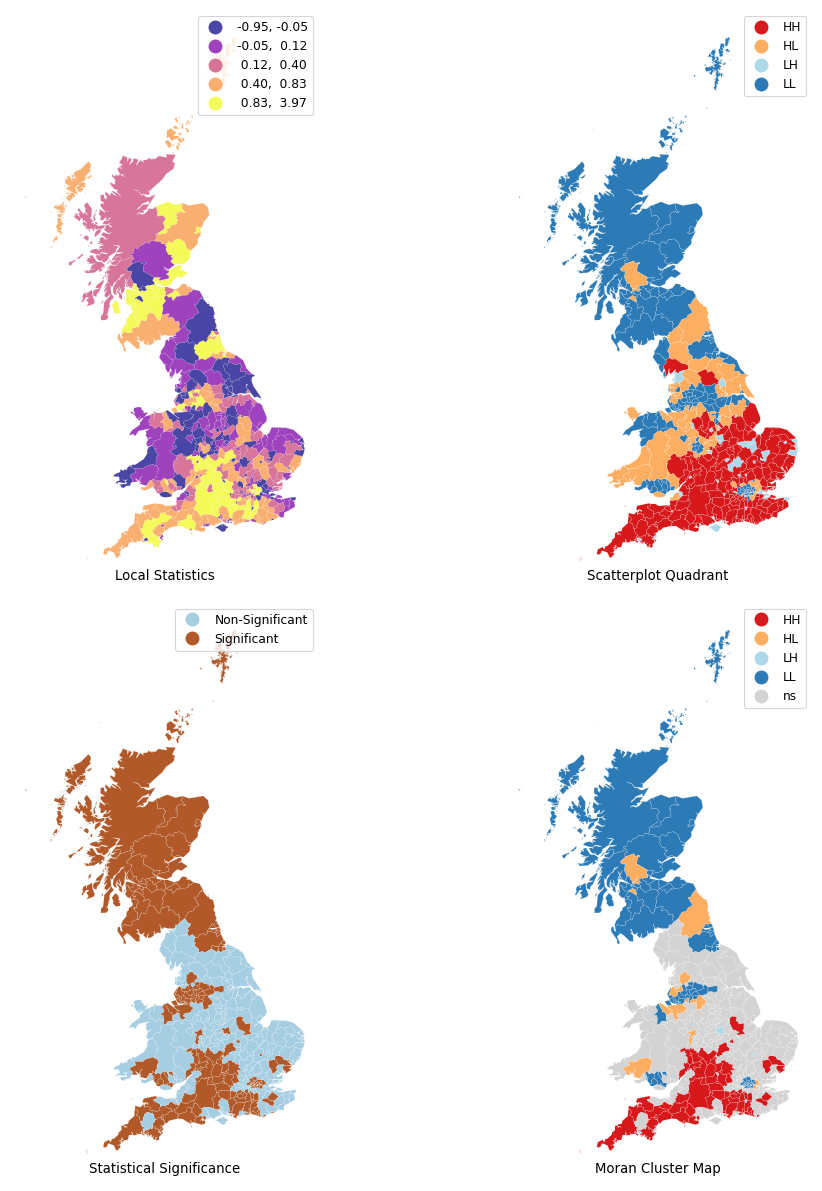

In [92]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

## insert code here
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa2.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)
# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa2, db2, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa2.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db2.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db2.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)
# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa2, db2, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

Based on the figures above, it seems that there is a unique geography for turnout in Britain. Based on the Moran Cluster Map (bottom right), we see that there was high voter turnout in areas in the south of the country, and low voter turnout in areas in the North of the country around Scotland.  

## Q.2 
Local statistics use *permutation-based* inference for their significance testing. This means that, to test the statistical significance of a local relationship, values of the observed variable are *shuffled* around the map. These large numbers of *random* maps are then used to compare against the observed map. Local inference requires some restrictions on how each shuffle occurs, since each observation must be "fixed" and compared to randomly-shuffle neighboring observations. The distribution of local statistics for each "shuffle" is contained in the `.rlisas` attribute of a Local Moran object. 
    
    
For the first observation/column in `lisas`, make a `sns.distplot` of its shuffled local statistics. Add a vertical line to the histogram using `plt.axvline()`.  (5pts)


In [94]:
shuffles = lisa.rlisas[:,0]
shuffles.shape

(380, 999)

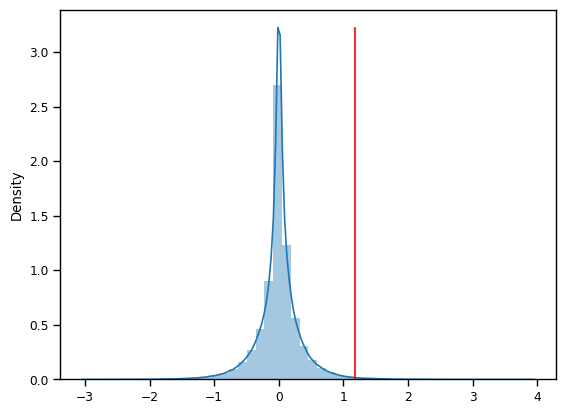

In [108]:
## insert code here
ax = sns.distplot(shuffles)

#Add vertical line
plt.axvline(lisa.Is[0], ymax = 0.95, color = 'r')

Do the same for the last observation as well. (1 pt)

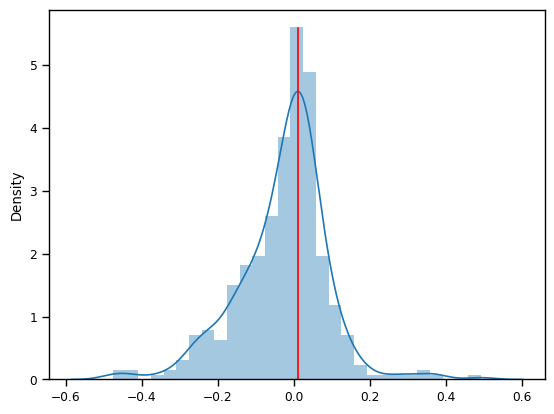

In [109]:
## insert code here
shuffles_last = lisa.rlisas[:,-1]

ax2 = sns.distplot(shuffles_last)
plt.axvline(lisa.Is[-1], ymax = 0.95, color = 'r')

Looking only at their permutation distributions, do you expect the first LISA statistic to be statistically-significant? Do you expect the last? (2 pts)


Based on the first permutation distribution, I would expect the first LISA statistic to be statistically-significant, as it is located in the right-most tail of the distribution. However, I do not expect the last LISA statistic to be statistically significant as it is located near the center of the permutation distribution, suggesting it could have been derived from a random distribution. 

In [ ]:
## Get the first value in lisa.Is (the LISA indicator)
## insert code here